In [3]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Utils.functions import *

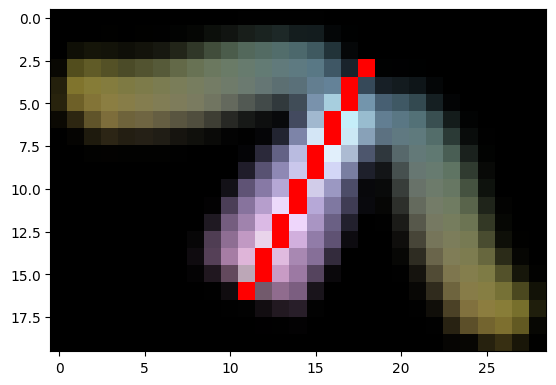

In [4]:
# Draws all lines in list on specified color
def drawLines(img: np.ndarray, lines: list, color: list[int] = [255,0, 0]):
    for [startAxis, endAxis] in lines:
        cv2.line(img, (int(startAxis[0]) , int(startAxis[1])), (int(endAxis[0]) , int(endAxis[1])), color, 1)
    return img

mnist = pd.read_csv('MNIST/mnist_test.csv')
img, dict = createAnySymmetry(random.randint(0,10000), mnist, ['simple', 'cross'], [0.5, 0.5])

drawLines(img, dict['symAxes'])
plt.imshow(img)
plt.show()

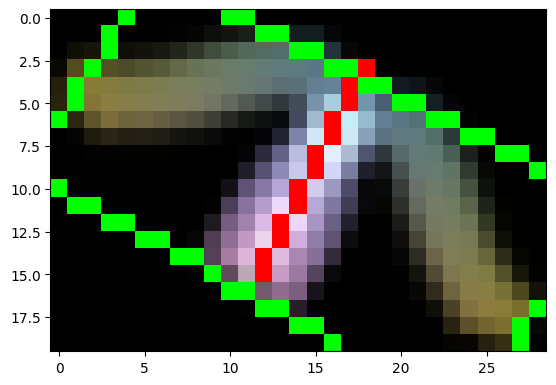

In [5]:
# Draws polygon on the image
def drawPolygon(img: np.ndarray, points: list, color: list[int] = [0, 255, 0]):
    for i in range(len(points)):
        if i != len(points)-1:
            cv2.line(img, (int(points[i][0]),int(points[i][1])), (int(points[i+1][0]),int(points[i+1][1])), color, 1)
        else:    
            cv2.line(img, (int(points[i][0]),int(points[i][1])), (int(points[0][0]),int(points[0][1])), color, 1)

# Returns bounding box points given parameters
def getBoundingBoxPoints(center: list, width: int, height: int, rotation: float):
    # Points for bounding box
    pts = [(center[0]-width/2 , center[1]-height/2), (center[0]+width/2 , center[1]-height/2), 
           (center[0]+width/2 , center[1]+height/2), (center[0]-width/2 , center[1]+height/2)]
    
    # Rotating
    rotationMatrix = cv2.getRotationMatrix2D(center, rotation, 1)
    return transformKeypoints(pts, rotationMatrix)

pts = getBoundingBoxPoints(dict['center'], dict['width'], dict['height'], dict['finalRotation'])

disp = img.copy()
drawPolygon(disp, pts)
plt.imshow(disp)
plt.show()

<h3>Drawing from dictionary</h3>

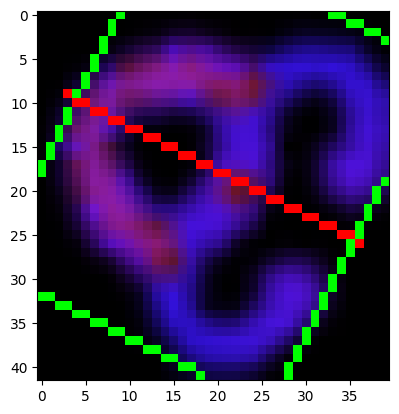

In [16]:
# Draws bounding box and symmetry axis from dictionary
def drawFromDict(src: np.ndarray, dict: dict):
    drawPolygon(src, getBoundingBoxPoints(dict['center'], dict['width'], dict['height'], dict['finalRotation']))
    drawLines(src, dict['symAxes'])

# Creating image and skewing it
img, dict = createAnySymmetry(random.randint(0,10000), mnist, ['simple', 'cross'], [0.5, 0.5])
drawFromDict(img, dict)

# Display
plt.imshow(img)
plt.show()

<h3>Skewing</h3>

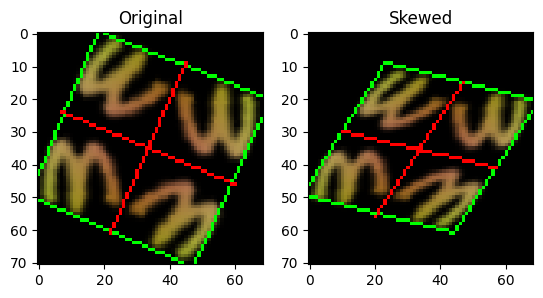

In [52]:
# Takes a list of segments and returns a list of points
def fromSegmentsToPoints(segments: list):
    points = []
    for symAxis in segments:
        points.append(symAxis[0])
        points.append(symAxis[1])
    return points

# Takes a list of points and returns a list of segments
def fromPointsTosegments(points: list):
    segments = []
    for i in range(len(points)//2):
        segments.append([points[i*2],points[i*2+1]])
    return segments

# Skews the point to the specified token
def skewPoints(pts: list, width: int, height: int, center, rotation: float, skewToken: dict):
    input_pts = getBoundingBoxPoints(center, width, height, 0)

    # Skewing box
    if skewToken['axis'] == 'Vertical':
        output_pts = np.float32([
            [(input_pts[0][0] + (width/2)*skewToken['skewPercX']), (input_pts[0][1] + (height/2)*skewToken['skewPercY'])],
            input_pts[1],
            [(input_pts[2][0] - (width/2)*skewToken['skewPercX']), (input_pts[2][1] - (height/2)*skewToken['skewPercY'])],
            input_pts[3]
        ])
    else:
        output_pts = np.float32([
            input_pts[0],
            [(input_pts[1][0] + (width/2)*skewToken['skewPercX']), (input_pts[1][1] + (height/2)*skewToken['skewPercY'])],
            input_pts[2],
            [(input_pts[3][0] + (width/2)*skewToken['skewPercX']), (input_pts[3][1] + (height/2)*skewToken['skewPercY'])],
        ])
    
    # Rotating box
    rotationMatrix = cv2.getRotationMatrix2D(center, rotation, 1)
    rotated_input =  np.float32(transformKeypoints(input_pts, rotationMatrix))
    output_pts =  np.float32(transformKeypoints(output_pts, rotationMatrix))

    # Creating transform Matrix
    M = cv2.getPerspectiveTransform(rotated_input, output_pts)

    return transformKeypoints(pts, M)

# Creating image and skewing it
img, dict = createAnySymmetry(random.randint(0,10000), mnist, ['simple', 'cross'], [0.5, 0.5])
skewed, skewToken = skewImage(img, dict['width'], dict['height'], dict['center'], dict['finalRotation'], 0.3, 0.3)

# Drawing bounding box and axes in normal image
drawFromDict(img, dict)
# Drawing bounding boc in skewed image
drawPolygon(
    skewed, 
    skewPoints(
        getBoundingBoxPoints(dict['center'], dict['width'], dict['height'], dict['finalRotation']),
        dict['width'],
        dict['height'],
        dict['center'],
        dict['finalRotation'],
        skewToken
    )
)

# Drawing SymAxis in skewed image
drawLines(
    skewed,
    fromPointsTosegments(
        skewPoints(
            fromSegmentsToPoints(
                dict['symAxes']
            ),
            dict['width'],
            dict['height'],
            dict['center'],
            dict['finalRotation'],
            skewToken
        )
    )
)

# Display
fig, ax = plt.subplots(1,2)
ax[0].imshow(img), ax[0].set_title(f'Original')
ax[1].imshow(skewed), ax[1].set_title('Skewed')
plt.show()

In [ ]:
# Draws off dictionary
def drawFromDictionary(img, dict):
    pass # DO THIS ONE AT SOME POINT I'D SAY
